In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
from geopy.distance import vincenty
%matplotlib inline

# Initialisation Data frame
### Création d'un data frame vide pour y ajouter ensuite les clusters de chaque zone

In [2]:
dfinal=pd.DataFrame(columns=('BarLong','BarLat','Rayon','Weight','NbDays','Month','Year','Id'))
dfinal.loc[0] =[0,0,0,0,0,0,0,0]

# Lecture des données
### Les données sont séparées en deux data frame par zone : un contenant toute les attaques de la zone et un contenant le reste des attaques

In [3]:
df = pd.read_csv('../data/aden.csv',sep=';')
df2 = df[df["large_area"]!="G"]

dfA = df[df["large_area"]=="A"]
dfA2 = df[df["large_area"]!="A"]

dfI = df[df["large_area"]=="I"]
dfI2 = df[df["large_area"]!="I"]

df=df[df["large_area"]=="G"]

size = len(df)

# Fonctions communes aux trois zones

In [4]:
#inscription du mois au même format qu'il soit composé d'un ou de deux chiffres
def monthCorrect(month):
    month=str(int(month))
    if len(month)==1:
        return '0'+month
    else:
        return month

In [5]:
#construction du dendrogramme
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (with max distance)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [10]:
#construction des clusters
def clusterise(date, max_d, df,zone):
    #sous ensemble des données correspondant à la date choisie
    clustersId = []
    subDf = df[df["date"]==date]
    subDate = date.split("-")
    #dans le cas où le cluster ne contient qu'un seul élément :
    if(len(subDf) == 1):
        maxIdx=dfinal.index.values.max() 
        dfinal.loc[maxIdx+1] =[subDf["longitude"].values[0], subDf["latitude"].values[0],0,1,1,subDate[1],subDate[0],date+'_'+str(1)+'_'+zone]
        df["id_cluster"].loc[subDf.index.values[0]]=date+'_'+str(1)+'_'+zone
        return dfinal
    
    #construction du dataframe 2D
    X = subDf[["longitude","latitude"]].values
    #clusterisation
    Z = linkage(X, 'ward', metric = 'euclidean')
    #affichage du dendrogram

    #fancy_dendrogram(
    #    Z,
    #    truncate_mode='lastp',
    #    p=12,
    #    leaf_rotation=90.,
    #    leaf_font_size=12.,
    #    show_contracted=True,
    #    max_d=max_d,  # arret du dendrogram
    #)
    #plt.show()
    
    #récuperation des clusters
    from scipy.cluster.hierarchy import fcluster
    clusters = fcluster(Z, max_d, criterion='distance')
      
    for p in range(0,len(subDf.index.values)):
        df["id_cluster"].loc[subDf.index.values[p]]=date+'_'+str(clusters[p])+'_'+zone
        #print subDf.index.values[clusters==1]
        #print subDf["jour (0)"][subDf.index.values[clusters==1]]
    
    #calcul du barycentre de chaque cluster
    centroidX = []
    centroidY = []
    for i in range(min(clusters),max(clusters)+1):
        x = np.mean(X[clusters==i,0])
        y = np.mean(X[clusters==i,1])
        point = (x,y)
        dist = []
        for j in range(0,len(X[clusters==i,0])):
            point2=(X[clusters==i,0][j], X[clusters==i,1][j])
            dist.append(vincenty(point, point2).kilometers)
        centroidX.append(x)
        centroidY.append(y)

        maxJ = max(subDf["jour (0)"][subDf.index.values[clusters==i]])
        minJ = min(subDf["jour (0)"][subDf.index.values[clusters==i]])
        
        nbDay = maxJ - minJ        
        maxIdx=dfinal.index.values.max() 
        dfinal.loc[maxIdx+1] =[x, y, max(dist),len(clusters[clusters==i]),nbDay,subDate[1], subDate[0],date+'_'+str(i)+'_'+zone]

    #affichage des clusters
    #plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    #affichage des barycentres
    #plt.scatter(centroidX,centroidY,cmap='prism')
    #plt.title('Clusters and their centroid')
    #plt.xlabel('Longitude')
    #plt.ylabel('Latitude')
    #plt.show()

## Zone G

In [11]:
# récupération des dates
df["mois (0)"]=df.apply(lambda row: monthCorrect(row['mois (0)']), axis=1)
df["date"]=df.apply(lambda row: str(row["Annee (0)"]) +"-"+ str(row["mois (0)"]), axis=1)

In [12]:
df["date"].unique()

array(['2010-10', '2010-01', '2010-02', '2010-03', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-11', '2010-04', '2010-12',
       '2008-02', '2008-03', '2008-04', '2008-05', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12', '2008-06', '2009-01',
       '2009-02', '2009-03', '2009-04', '2009-05', '2009-07', '2009-12',
       '2009-06', '2009-08', '2009-09', '2009-10', '2009-11', '2011-01',
       '2011-04', '2011-09', '2011-02', '2011-05', '2011-07', '2011-08',
       '2011-10', '2011-03', '2011-11', '2011-06', '2011-12', '2012-02',
       '2012-12', '2012-03', '2012-04', '2012-01', '2012-06', '2012-05',
       '2012-07', '2013-03', '2013-06', '2013-05', '2013-07', '2013-12',
       '2014-01', '2014-04', '2014-02', '2014-03', '2014-08', '2014-12'], dtype=object)

In [ ]:
# génération des clusters
df["id_cluster"] = ""
for i in range(0,len(df["date"].unique())):
    clusterise(df["date"].unique()[i], 4.5,df,"G")

In [197]:
dfinal.head()

,BarLong,BarLat,Rayon,Weight,NbDays,Month,Year,Id
0,0.000000,0.000000,0.000000,0,0,0,0,0
1,49.162986,13.191875,47.973162,4,25,10,2010,2010-10_1_G
2,55.191667,13.616667,128.608970,2,2,10,2010,2010-10_2_G
3,47.850833,12.711389,96.305994,3,16,01,2010,2010-01_1_G
4,47.908333,13.033333,93.623201,2,2,02,2010,2010-02_1_G


In [ ]:
frames = [df, df2]

result = pd.concat(frames)
print result.head()
result.to_csv("../data/aden.csv",sep=';', index=False)

## Zone A

In [23]:
dfA["mois (0)"]=dfA.apply(lambda row: monthCorrect(row['mois (0)']), axis=1)
dfA["date"]=dfA.apply(lambda row: str(row["Annee (0)"]) +"-"+ str(row["mois (0)"]), axis=1)
dfA["date"].unique()
print dfA["date"].unique()

['2010-01' '2010-03' '2010-04' '2010-05' '2010-10' '2010-11' '2010-12'
 '2010-06' '2010-02' '2008-02' '2008-03' '2008-04' '2009-12' '2009-06'
 '2009-04' '2009-07' '2009-09' '2009-10' '2011-03' '2011-01' '2011-02'
 '2011-04' '2011-05' '2011-10' '2011-12' '2011-06' '2011-09' '2011-11'
 '2012-02' '2012-03' '2012-04' '2012-05' '2012-06' '2012-12' '2012-01'
 '2013-01' '2013-06' '2013-07' '2013-10' '2013-11' '2013-12' '2014-07'
 '2014-09' '2014-10' '2014-03']


2010-01
[0]
2010-03
[  3   4   5  63  64  65  71  73 207]


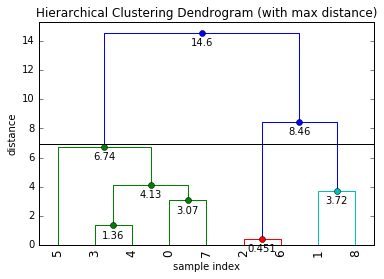

[1 3 2 1 1 1 2 1 3]
15
1
21


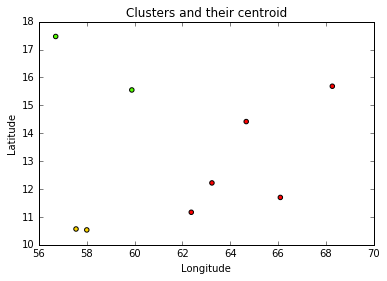

2010-04
[  7  46  75  81  82  83 156 160 161]


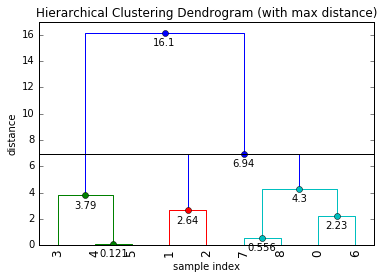

[3 2 2 1 1 1 3 3 3]
2
16
7


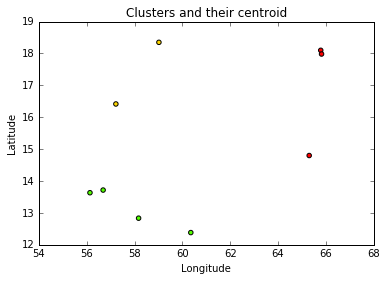

2010-05
[13 15]


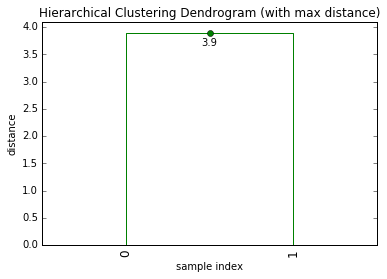

[1 1]
7


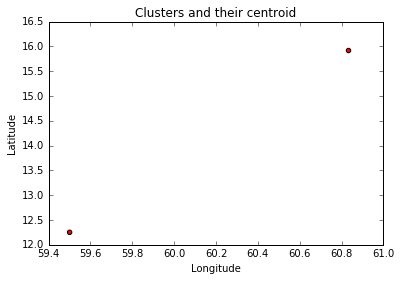

2010-10
[ 24 101 102]


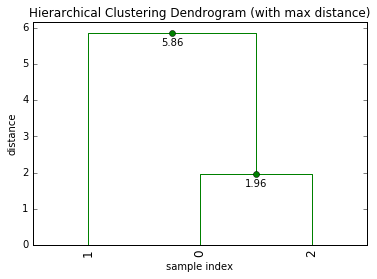

[1 1 1]
3


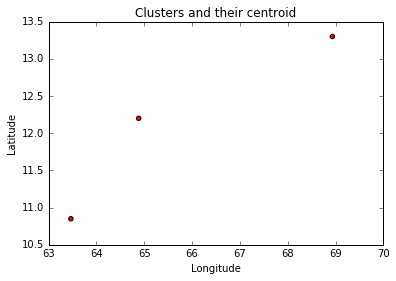

2010-11
[ 28  29  30  31  32  35 113 117 119 121 125 126 127 128 129 132 133]


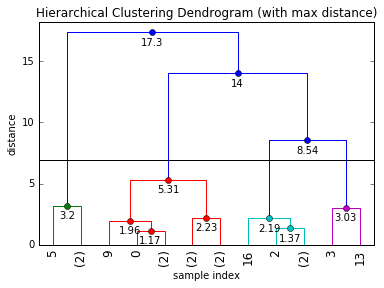

[2 3 3 4 1 1 3 2 2 2 1 2 2 4 2 2 3]
6
17
18
5


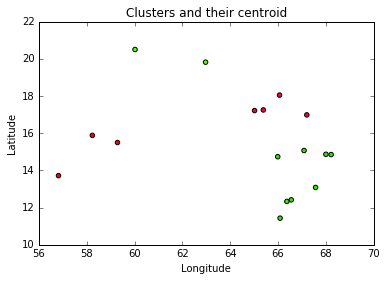

2010-12
[ 40  41 137 139 140 141 142 143 144 145]


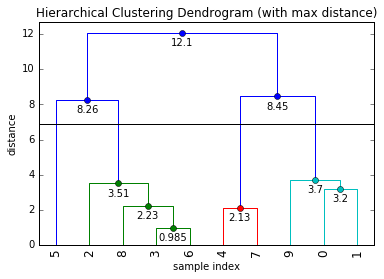

[4 4 1 1 3 2 1 3 1 4]
12
0
7
2


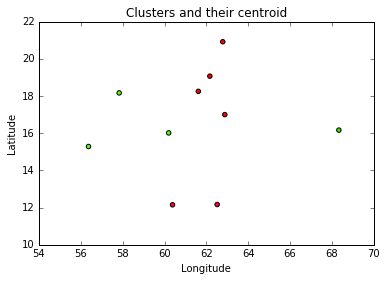

2010-06
[90]
2010-02
[206]
2008-02
[208]
2008-03
[209 210]


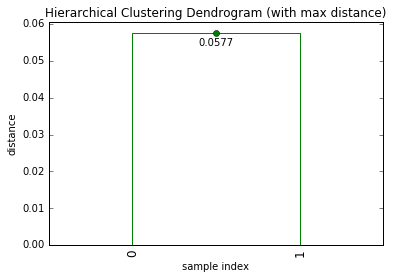

[1 1]
23


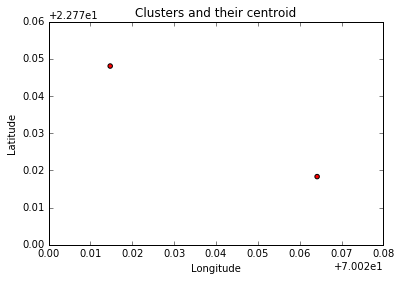

2008-04
[267]
2009-12
[358 429 432]


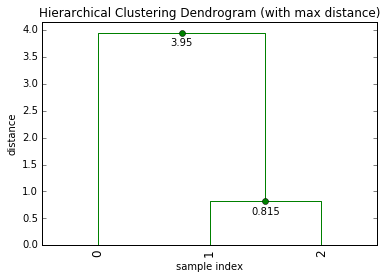

[1 1 1]
29


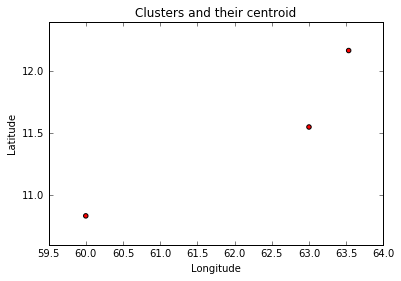

2009-06
[380 546]


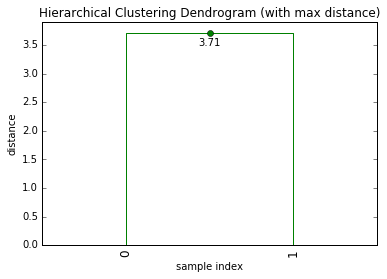

[1 1]
2


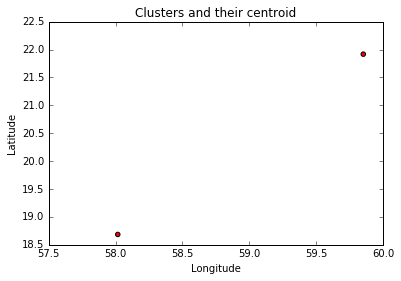

2009-04
[479 480 545]


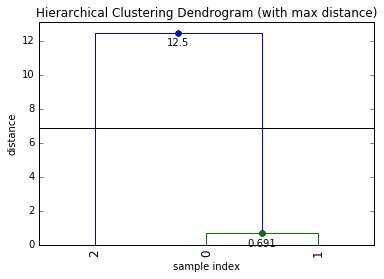

[1 1 2]
1
0


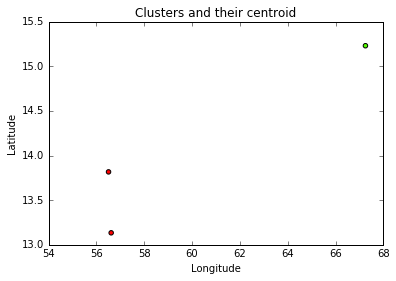

2009-07
[547]
2009-09
[548]
2009-10
[549]
2011-03
[550 570 571 572 573 574 575 643 644 646 647 648 650 651 654 655 656 657
 658 659 663 664]


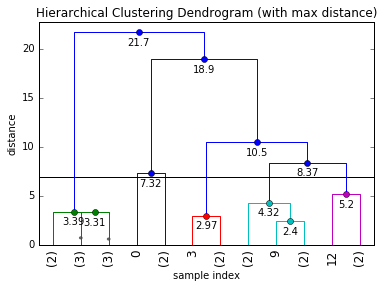

[3 1 5 4 5 2 6 6 4 5 1 5 6 1 1 1 1 1 4 5 2 1]
23
0
0
13
17
25


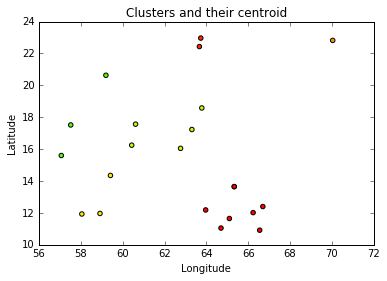

2011-01
[554 555 556 557 558 559 560 561 562 564 604 605 606 607 608 609 610 612
 613 614 615 616 617 618 620 621 622 623 624 626]


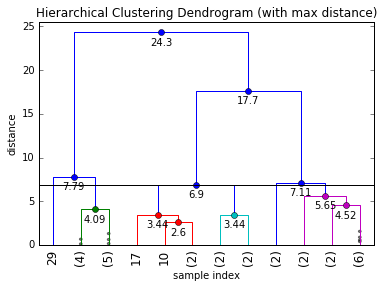

[6 6 6 6 1 4 1 6 1 4 3 6 1 1 1 1 1 3 6 5 5 4 6 6 3 1 6 3 4 2]
17
0
20
12
1
18


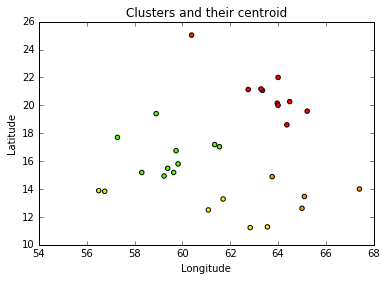

2011-02
[565 566 567 568 569 628 630 631 632 633 634 635 636 637 638 639 640]


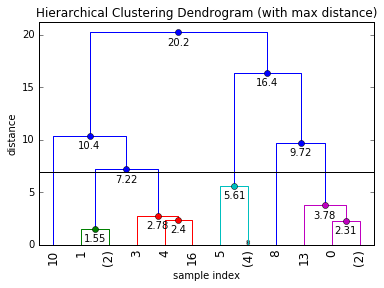

[5 1 1 2 2 4 1 5 6 5 3 4 4 5 4 4 2]
10
10
0
24
23
0


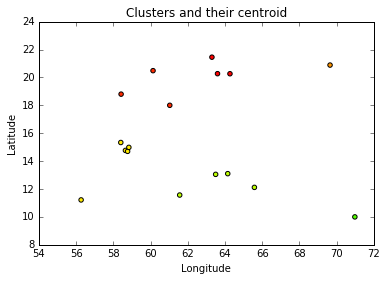

2011-04
[576 577 580 581 667 670]


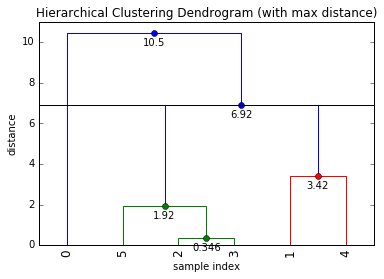

[3 2 1 1 2 1]
4
3
0


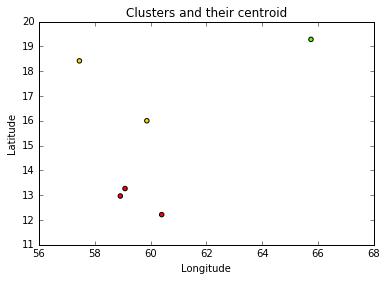

2011-05
[583 672 673 675 676 677 678 679 681 683 687 688]


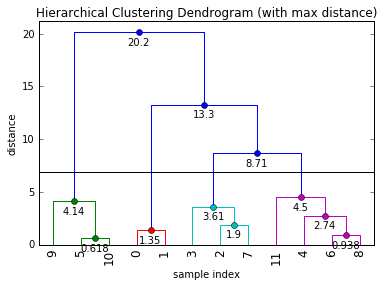

[2 2 3 3 4 1 4 3 4 1 1 4]
11
1
9
12


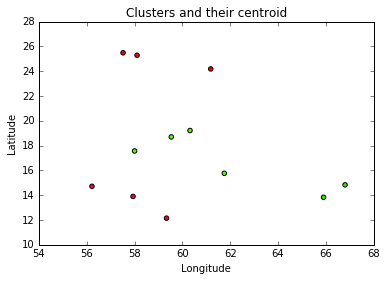

2011-10
[587 699 703]


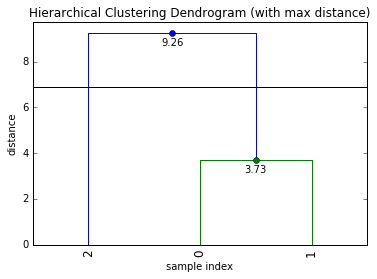

[1 1 2]
8
0


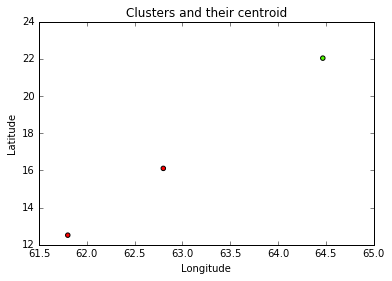

2011-12
[590 717]


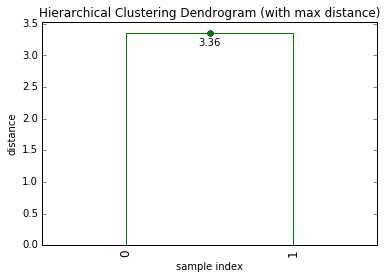

[1 1]
23


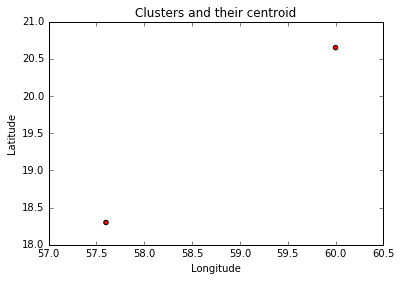

2011-06
[689 690 691 694 695]


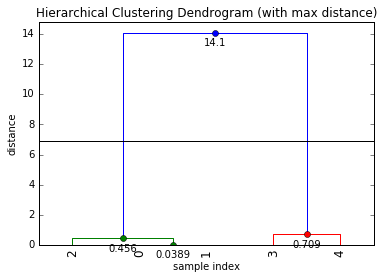

[1 1 1 2 2]
1
2


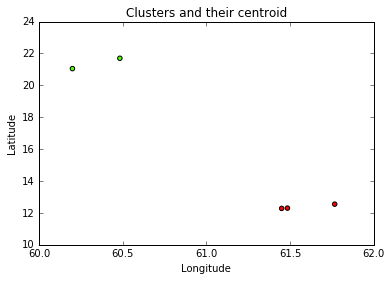

2011-09
[697]
2011-11
[712 716]


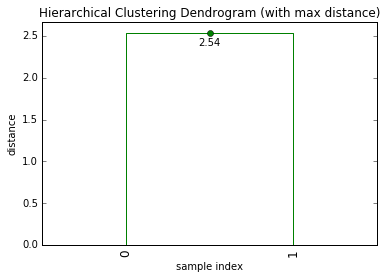

[1 1]
28


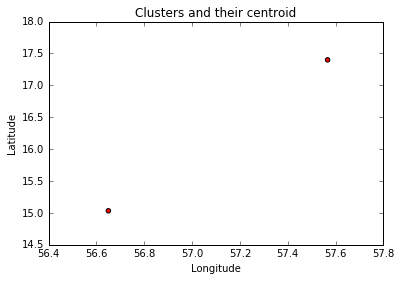

2012-02
[786 811 813 814 815]


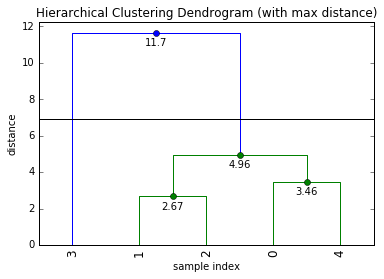

[1 1 1 2 1]
21
0


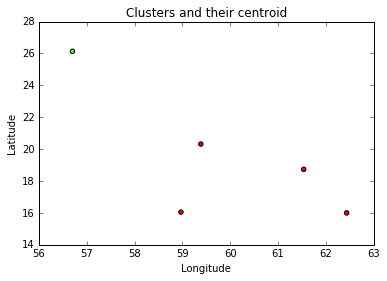

2012-03
[788 816 818 819 820 822]


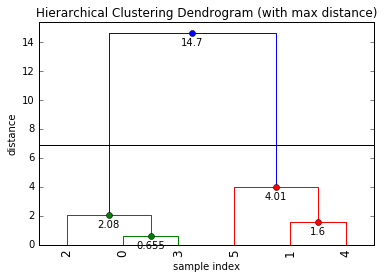

[1 2 1 1 2 2]
22
15


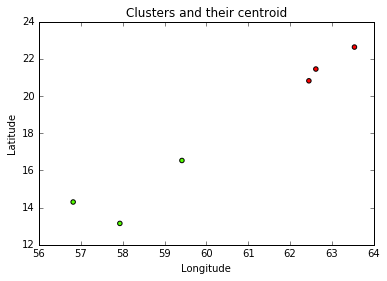

2012-04
[791 824 825 826]


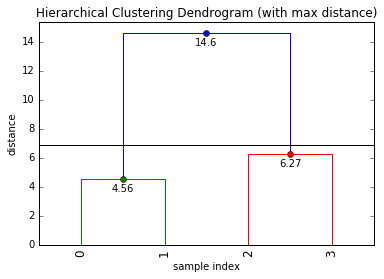

[1 1 2 2]
2
5


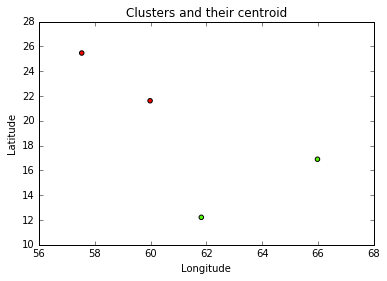

2012-05
[792 828 829 830 831]


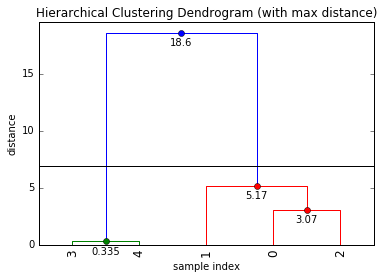

[2 2 2 1 1]
5
1


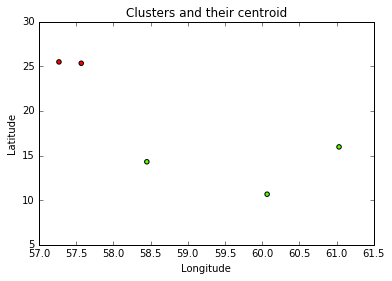

2012-06
[793 832 833]


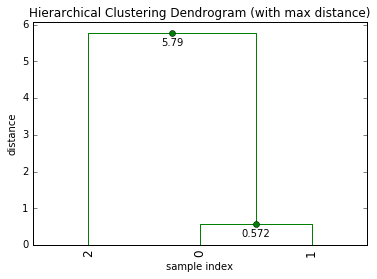

[1 1 1]
5


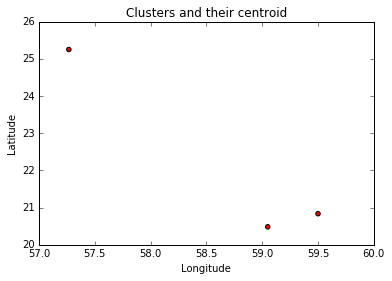

2012-12
[794 836 837]


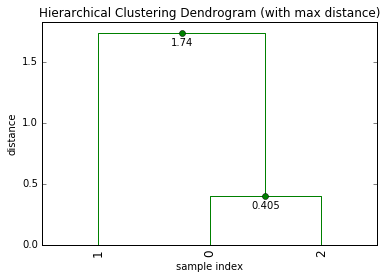

[1 1 1]
5


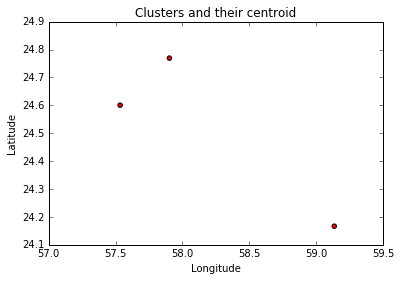

2012-01
[802 804 805 807]


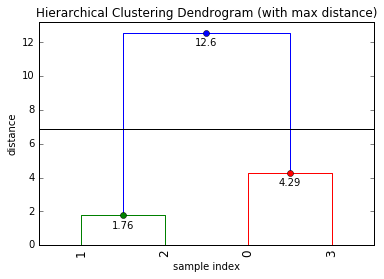

[2 1 1 2]
4
15


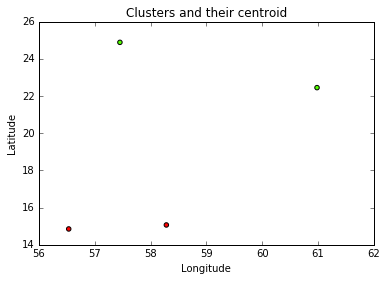

2013-01
[861]
2013-06
[863]
2013-07
[864]
2013-10
[865 866]


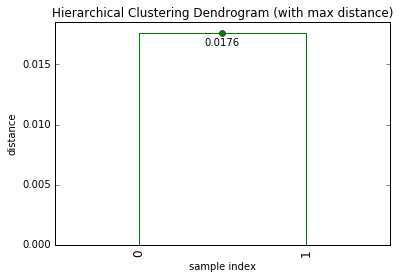

[1 1]
8


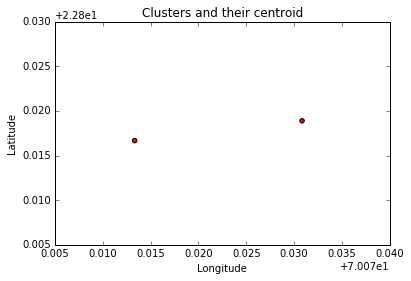

2013-11
[867 868]


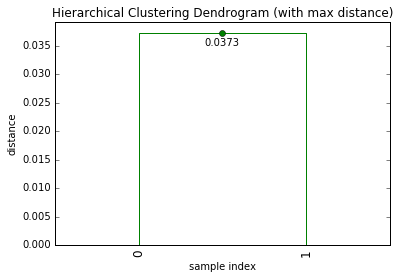

[1 1]
0


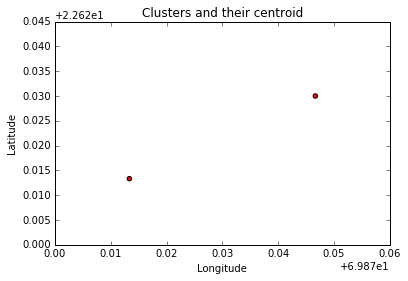

2013-12
[869]
2014-07
[888 889]


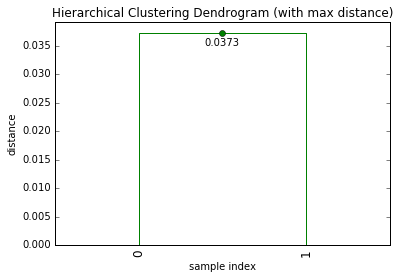

[1 1]
1


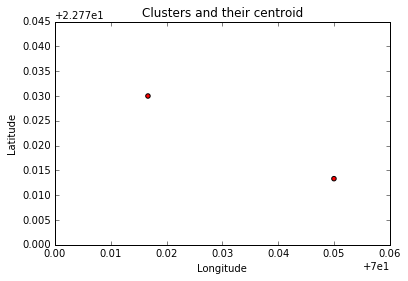

2014-09
[890 891 892 908]


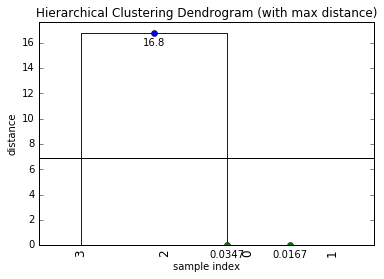

[1 1 1 2]
12
0


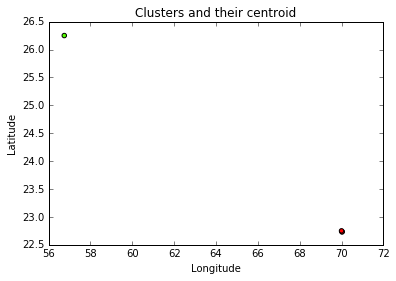

2014-10
[893]
2014-03
[907]


In [24]:
dfA["id_cluster"] = ""
for i in range(0,len(dfA["date"].unique())):
    clusterise(dfA["date"].unique()[i], 6.9,dfA,"A")

In [184]:
frames = [dfA, dfA2]

result = pd.concat(frames)
print result.head()

    Kidnapping   meurtre  Annee (0)  Guns  Knives   Nombre P  Min  \
0            1         0       2010     0        0             -1   
3            1         0       2010     0        0             -1   
4            1         0       2010     0        0             -1   
5            1         0       2010     0        0             -1   
7            0         0       2010     0        0             -1   

   Nombre P  max  RPG  Vol �_ bord  blessթes ...  mousson  \
0             -1    0            0         0 ...        0   
3             -1    0            0         0 ...        0   
4             -1    0            0         0 ...        0   
5             -1    0            0         0 ...        0   
7             -1    0            0         0 ...        0   

                                       newDescriptif         new_type  \
0  pirates hijacked a ship underway and took her ...  Vehicle Carrier   
3  armed pirates attacked, boarded and hijacked t...  Vehicle Carrier   

## Zone I

In [26]:
dfI["mois (0)"]=dfI.apply(lambda row: monthCorrect(row['mois (0)']), axis=1)
dfI["date"]=dfI.apply(lambda row: str(row["Annee (0)"]) +"-"+ str(row["mois (0)"]), axis=1)
dfI["date"].unique()

array(['2010-03', '2010-04', '2010-05', '2010-09', '2010-10', '2010-11',
       '2010-12', '2010-08', '2008-08', '2008-09', '2008-04', '2008-05',
       '2008-11', '2008-02', '2008-03', '2008-07', '2008-10', '2008-12',
       '2009-05', '2009-12', '2009-03', '2009-04', '2009-10', '2009-11',
       '2009-01', '2009-02', '2009-08', '2009-09', '2011-03', '2011-05',
       '2011-01', '2011-04', '2011-06', '2011-09', '2011-10', '2011-11',
       '2011-07', '2011-08', '2011-02', '2012-11', '2012-03', '2012-05',
       '2012-10', '2012-02', '2012-01', '2013-02', '2013-03', '2013-05',
       '2013-01', '2013-04', '2013-10', '2013-11', '2014-03', '2014-01',
       '2014-04', '2014-02'], dtype=object)

2010-03
[ 1  2 59 60 61 62 66 67 68 69 70 72]


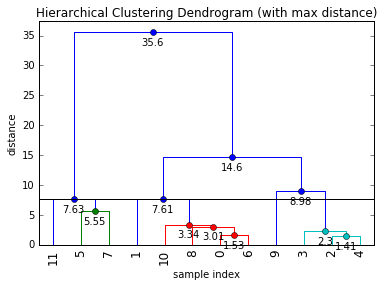

[3 4 5 5 5 1 3 1 3 6 3 2]
17
0
28
0
1
0


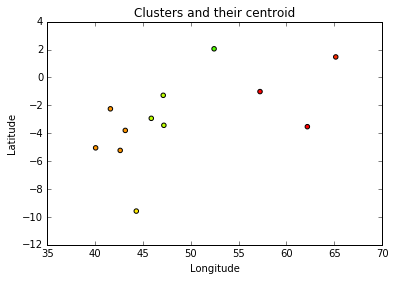

2010-04
[ 6  8  9 10 11 12 74 77 78 79 80]


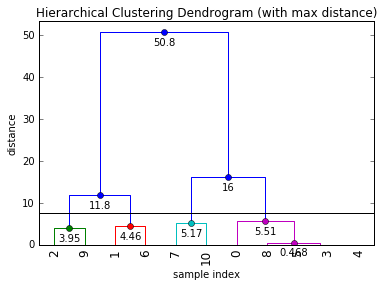

[4 2 1 4 4 4 2 3 4 1 3]
8
3
10
14


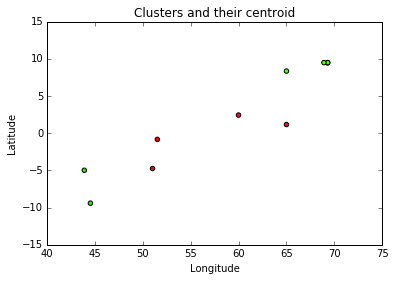

2010-05
[14 56 84 85 86 87 88 89]


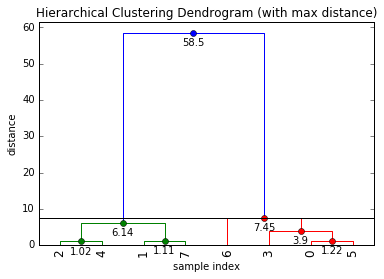

[2 1 1 2 1 2 2 1]
26
15


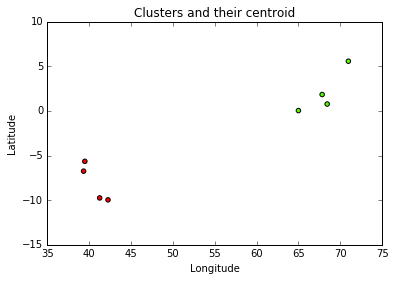

2010-09
[16 17 91 92 93 94]


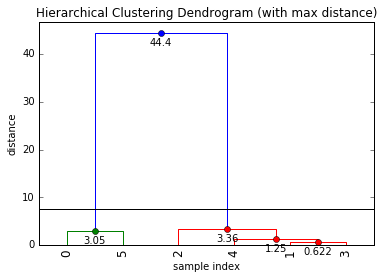

[1 2 2 2 2 1]
4
3


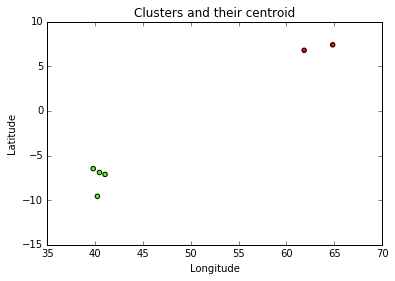

2010-10
[ 18  19  20  21  22  26  95  96  97  98  99 100 103 104]


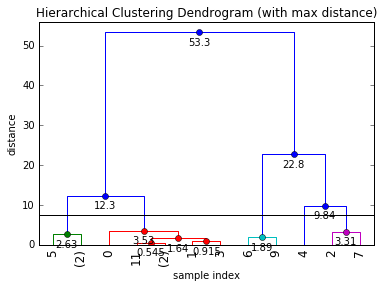

[2 2 4 2 5 1 3 4 1 3 1 2 2 2]
21
20
17
2
0


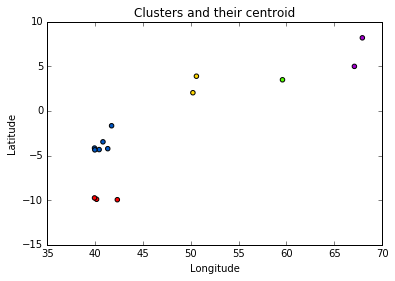

2010-11
[ 27  33  34 105 106 107 108 109 110 111 112 114 115 116 118 120 122 123
 124 130 131 134]


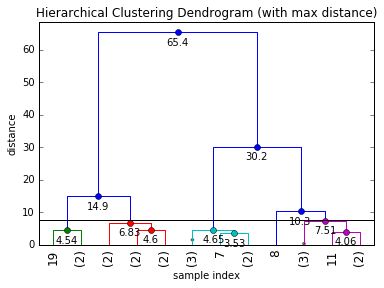

[3 2 2 3 3 2 3 3 5 4 2 4 3 2 4 1 4 4 4 1 1 2]
7
28
14
13
0


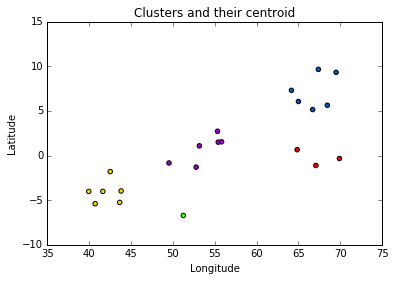

2010-12
[ 36  37  38  39 135 136 138]


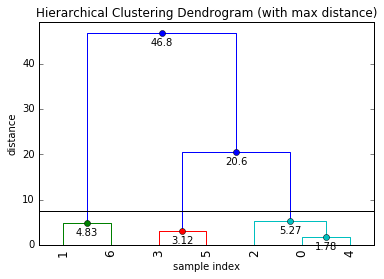

[3 1 3 2 3 2 1]
3
17
9


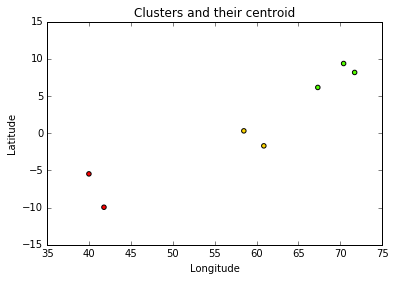

2010-08
[57 58]


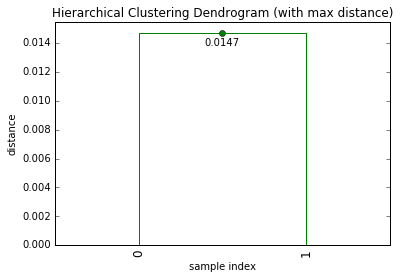

[1 1]
0


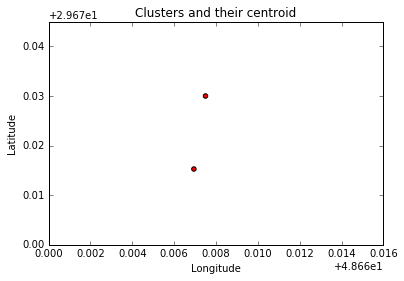

2008-08
[211 261 262 263]


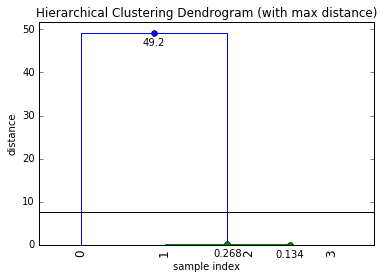

[2 1 1 1]
1
0


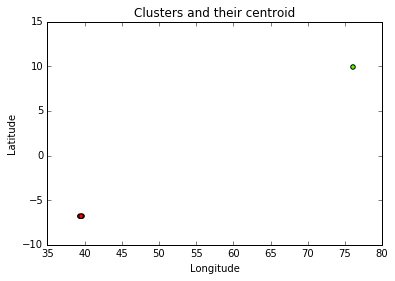

2008-09
[212 215 216 217 264 265 266 270 271]


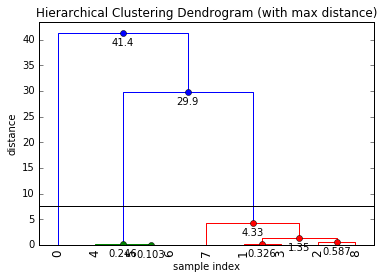

[3 2 2 2 1 1 1 2 2]
5
12
0


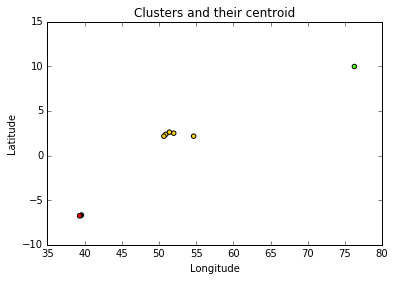

2008-04
[213 258 259]


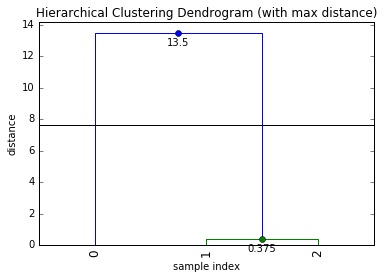

[2 1 1]
14
0


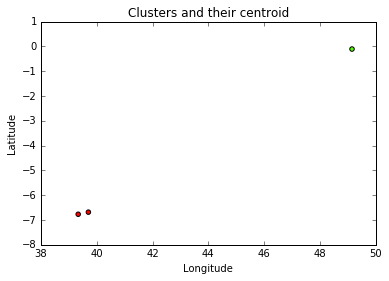

2008-05
[214 269]


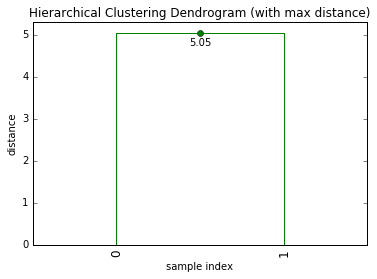

[1 1]
13


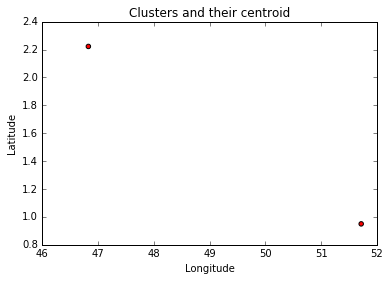

2008-11
[218 273 274 275]


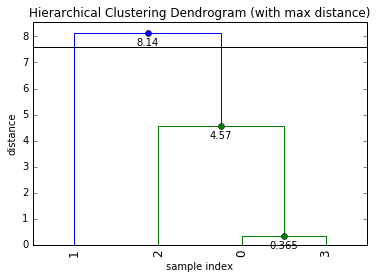

[1 2 1 1]
2
0


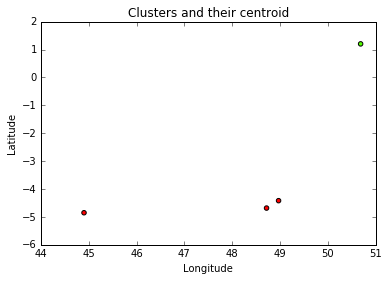

2008-02
[254 255]


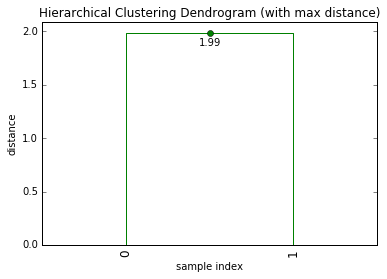

[1 1]
11


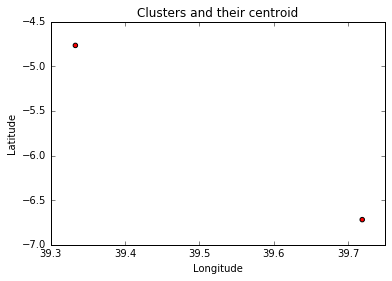

2008-03
[256 257 268]


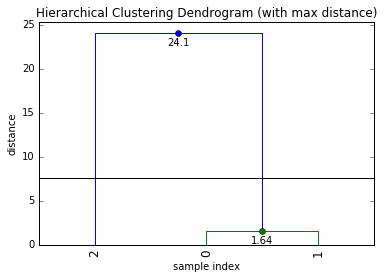

[1 1 2]
10
0


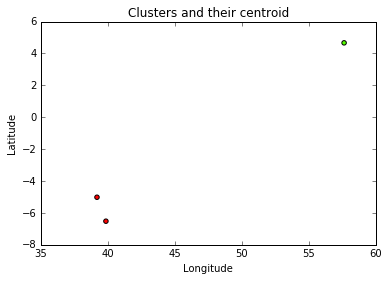

2008-07
[260]
2008-10
[272 335]


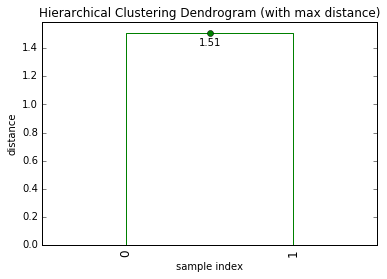

[1 1]
14


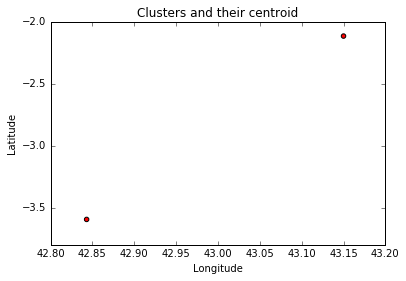

2008-12
[276]
2009-05
[336 347 348 379 406 407 408 409 410 411]


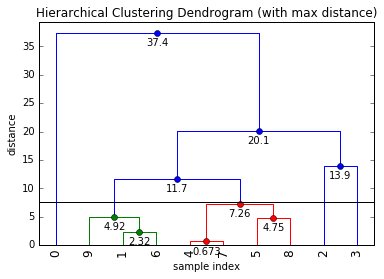

[5 1 3 4 2 2 1 2 2 1]
17
11
0
0
0


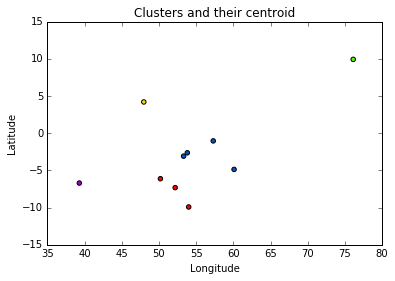

2009-12
[337 359 360 430 431]


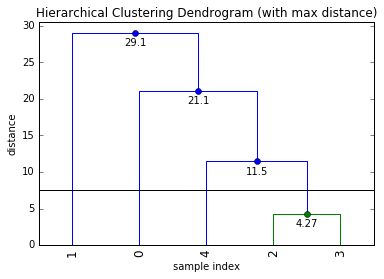

[3 4 1 1 2]
21
0
0
0


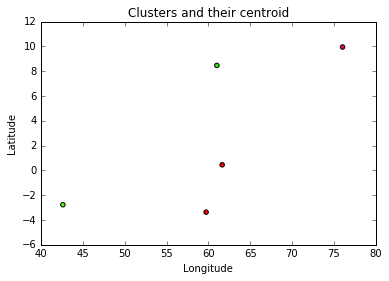

2009-03
[338 339 340 383 384 385 386 387 388 389 390 391 392 393 394 395 544]


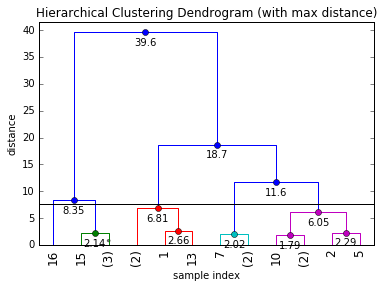

[3 3 5 1 1 5 1 4 5 5 5 3 4 3 4 1 2]
21
0
4
8
15


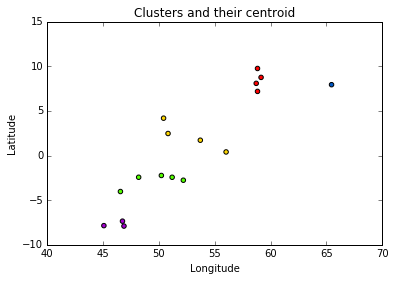

2009-04
[341 342 343 344 345 346 377 378 396 397 398 399 400 401 402 403 404 405]


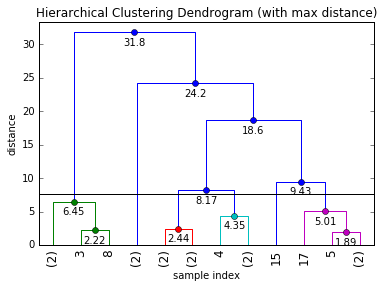

[3 1 5 1 4 5 2 2 1 1 4 3 3 5 3 6 4 5]
5
12
25
19
24
0


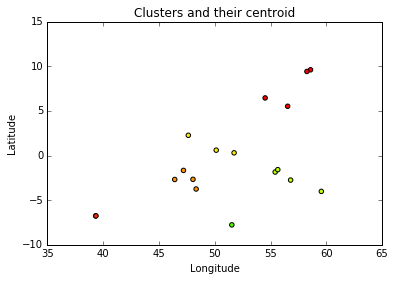

2009-10
[349 350 351 352 353 414 415 416 417]


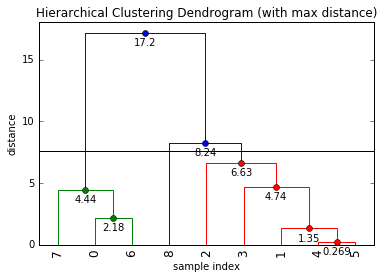

[1 2 2 2 2 2 1 1 3]
23
25
0


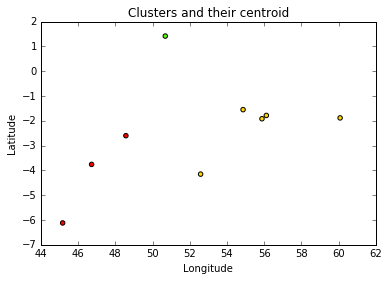

2009-11
[354 355 356 357 418 419 420 421 422 423 424 425 426 427 428]


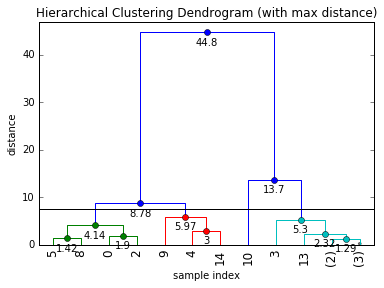

[1 3 1 3 2 1 3 3 1 2 4 3 3 3 2]
14
24
20
0


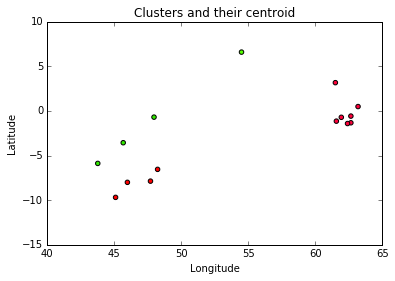

2009-01
[375 543]


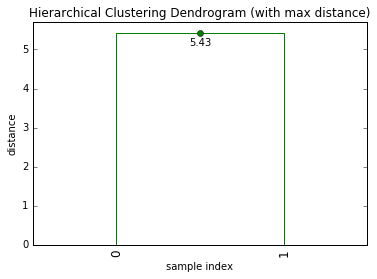

[1 1]
20


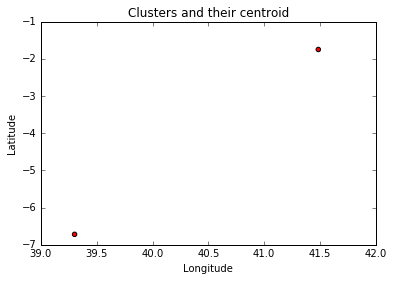

2009-02
[376 382]


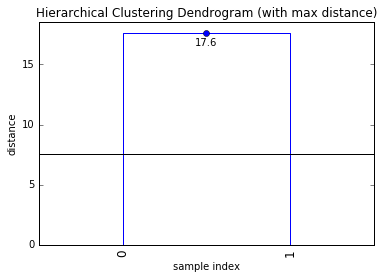

[1 2]
0
0


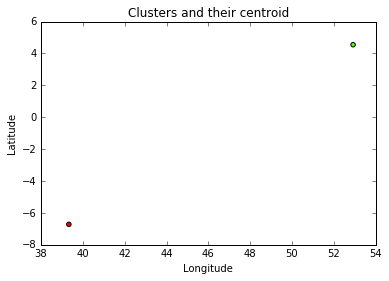

2009-08
[412]
2009-09
[413]
2011-03
[551 642 645 649 652 653 660 661 662]


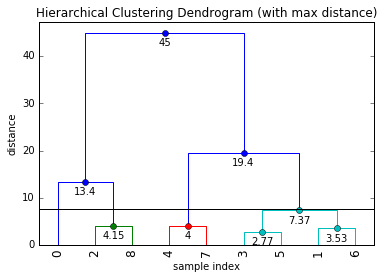

[2 4 1 4 3 4 4 3 1]
20
0
15
18


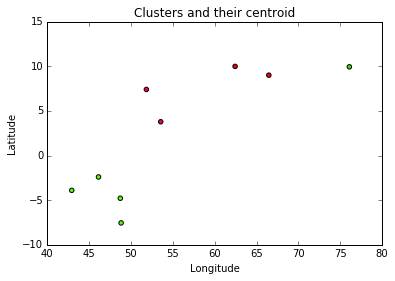

2011-05
[552 680 684 685 686]


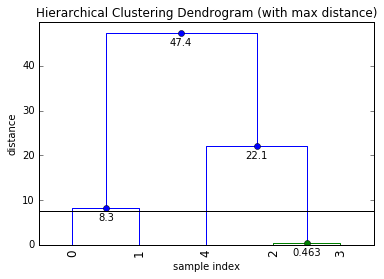

[1 2 3 3 4]
0
0
0
0


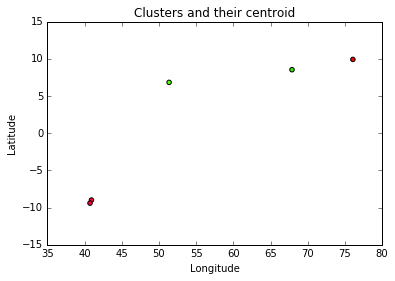

2011-01
[563 602 603 619 625 627]


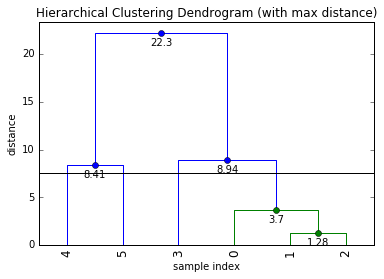

[3 3 3 4 1 2]
0
0
21
0


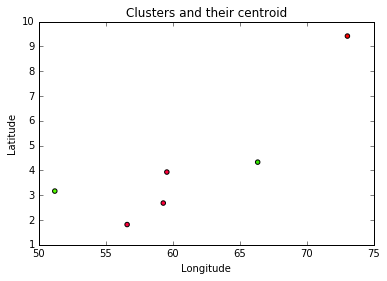

2011-04
[579 582 666 668 669 671]


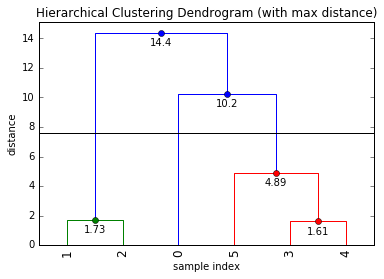

[3 1 1 2 2 2]
27
1
0


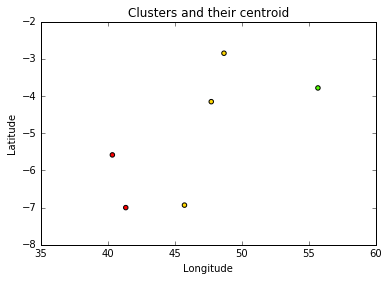

2011-06
[584 692 693]


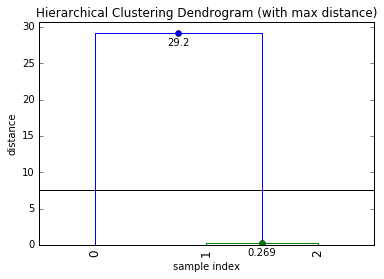

[2 1 1]
0
0


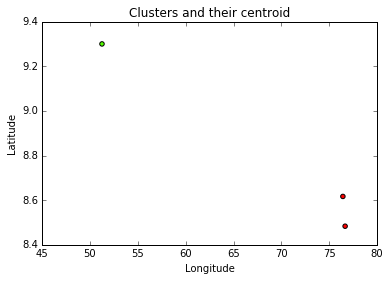

2011-09
[585 696]


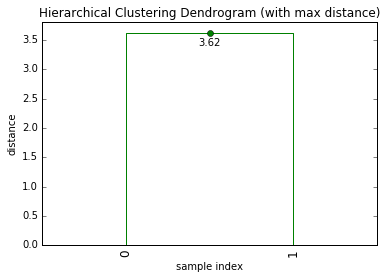

[1 1]
3


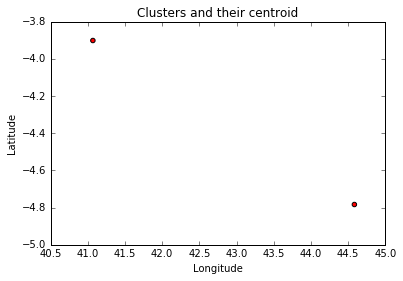

2011-10
[588 698 700 701 702 704 705 706 707 708 709 710 711]


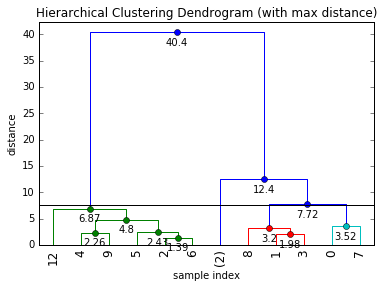

[4 3 1 3 1 1 1 4 3 1 2 2 1]
28
0
21
9


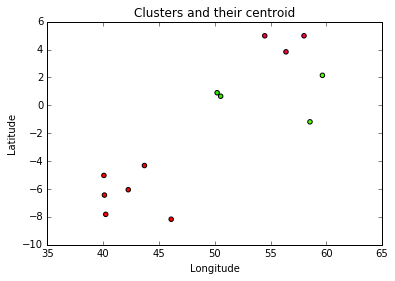

2011-11
[589 713 715]


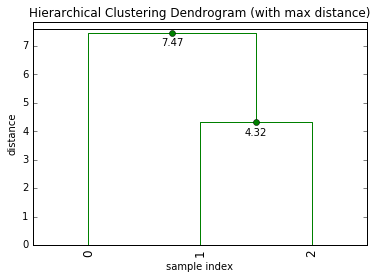

[1 1 1]
18


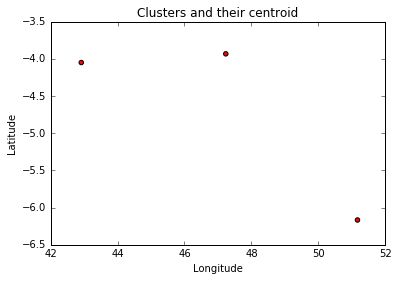

2011-07
[599]
2011-08
[600]
2011-02
[629]
2012-11
[785]
2012-03
[789 790 817 821 823]


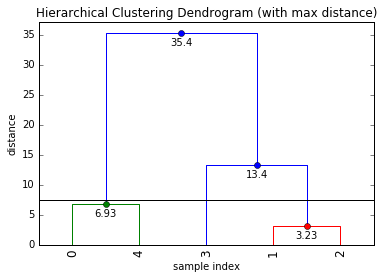

[1 2 2 3 1]
1
7
0


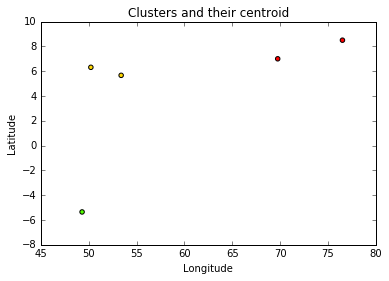

2012-05
[798 799 827]


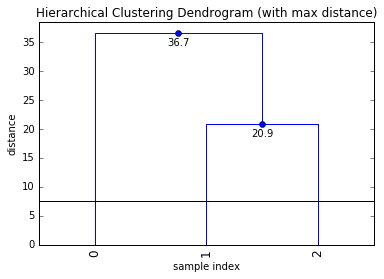

[3 1 2]
0
0
0


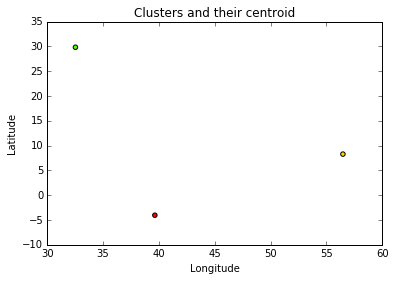

2012-10
[800 835]


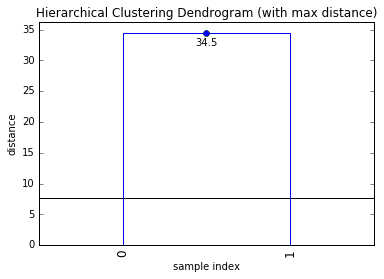

[1 2]
0
0


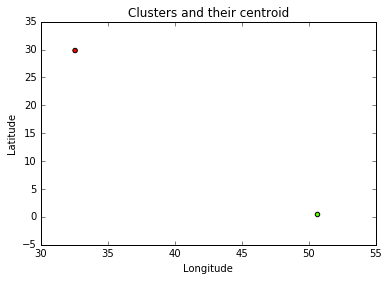

2012-02
[801 809 810 812]


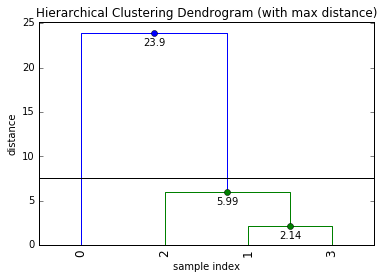

[2 1 1 1]
12
0


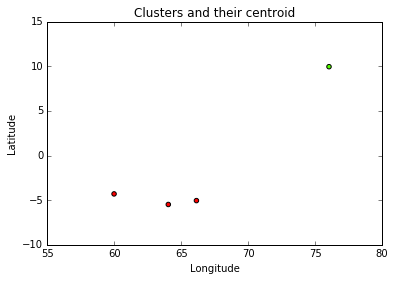

2012-01
[803 808 860]


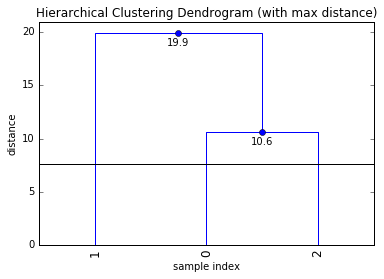

[1 3 2]
0
0
0


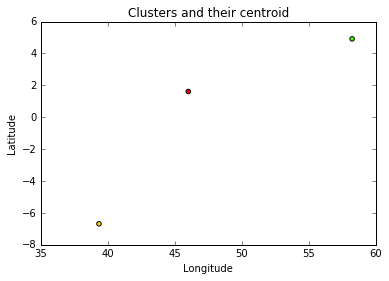

2013-02
[862 875]


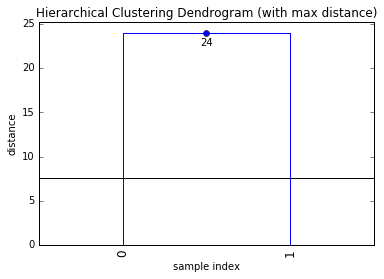

[1 2]
0
0


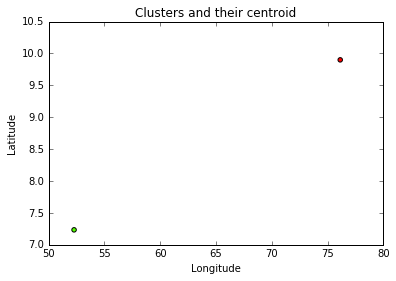

2013-03
[872]
2013-05
[873]
2013-01
[874]
2013-04
[876]
2013-10
[877]
2013-11
[878 879]


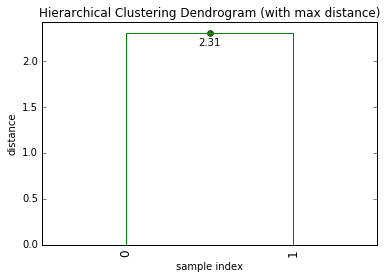

[1 1]
3


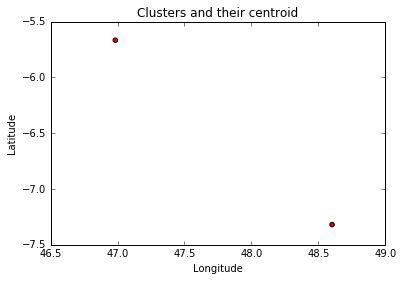

2014-03
[887]
2014-01
[894]
2014-04
[895]
2014-02
[897]


In [27]:
dfI["id_cluster"] = ""
for i in range(0,len(dfI["date"].unique())):
    clusterise(dfI["date"].unique()[i], 7.6, dfI,"I")

In [87]:
frames = [dfI, dfI2]

result = pd.concat(frames)
print result.head()

    Kidnapping   meurtre  Annee (0)  Guns  Knives   Nombre P  Min  \
1            1         0       2010     1        0             11   
2            1         0       2010     0        0             -1   
6            1         0       2010     0        0             -1   
8            0         0       2010     1        0             -1   
9            0         0       2010     0        0             -1   

   Nombre P  max  RPG  Vol �_ bord  blessթes ...  mousson  \
1             11    1            1         1 ...        0   
2             -1    0            0         0 ...        0   
6             -1    0            0         0 ...        0   
8             -1    1            0         0 ...        0   
9             -1    0            0         0 ...        0   

                                       newDescriptif         new_type  \
1  eleven pirates in three skiffs armed with guns...           Vessel   
2  armed pirates attacked and hijacked a tanker u...           Tanker   

# Inscription dans le fichier

In [ ]:
dfinal.to_csv("../data/aden_golfe_matrix_cluster.csv",sep=';', encoding='utf-8', index=False)